In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

1 2
possible subordinates [1, 2]
after popping []
##current supervisor 0
####current subordinate 1
i 1
####current subordinate 2
i 1
2 4
possible subordinates [3, 4, 5, 6]
after popping [2]
##current supervisor 1
####current subordinate 3
i 2
####current subordinate 4
i 2
after popping []
##current supervisor 2
####current subordinate 5
i 2
####current subordinate 6
i 2
3 8
possible subordinates [7, 8, 9, 10, 11, 12, 13, 14]
after popping [4, 5, 6]
##current supervisor 3
####current subordinate 7
i 3
####current subordinate 8
i 3
after popping [5, 6]
##current supervisor 4
####current subordinate 9
i 3
####current subordinate 10
i 3
after popping [6]
##current supervisor 5
####current subordinate 11
i 3
####current subordinate 12
i 3
after popping []
##current supervisor 6
####current subordinate 13
i 3
####current subordinate 14
i 3
4 16
possible subordinates [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
after popping [8, 9, 10, 11, 12, 13, 14]
##current supervisor 

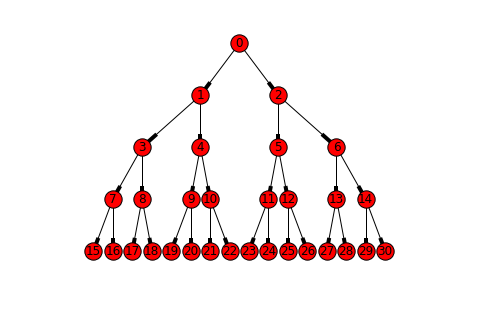

In [2]:
num_levels = 5
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)
i = 1
leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        print "after popping", leaf_nodes_last_level
        print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

print leaf_nodes_last_level
print leaf_nodes_next_level

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [3]:
def sample_h(level, mean_info = 0.7, sd_info = 0.05, dmu = 0.1):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    mu = mean_info - (dmu * (level-1))
    sigma = sd_info
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

def sample_alpha(mu = 0.5, sigma = 0.1):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

def sample_change_in_alpha(mu = 0.1, sigma = 0.01):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [4]:
mean_trust = 0.5
sd_trust = 0.1
mean_info_higehst_level = 0.7
dmu_each_level = mean_info_higehst_level / (num_levels - 1)
mean_change_in_alpha = 0.05
sd_change_in_alpha = 0.001

for edge in G.edges():
    subordinate_node = edge[1]
    current_h = sample_h(levels_of_nodes[subordinate_node], mean_info = mean_info_higehst_level, dmu = dmu_each_level)
    current_alpha = sample_alpha(mean_trust, sd_trust)
    G[edge[0]][edge[1]]['H'] = current_h
    G[edge[0]][edge[1]]['alpha'] = current_alpha
    

In [5]:
nx.get_edge_attributes(G, 'alpha')

{(0, 1): 0.58519292126516309,
 (0, 2): 0.48830109137452915,
 (1, 3): 0.40759243198872658,
 (1, 4): 0.45191872898383723,
 (2, 5): 0.54215719704342791,
 (2, 6): 0.33021942968775914,
 (3, 7): 0.61716995691310872,
 (3, 8): 0.56279014227692226,
 (4, 9): 0.36874117889828839,
 (4, 10): 0.55419650220619188,
 (5, 11): 0.58493370582539306,
 (5, 12): 0.50402896483830595,
 (6, 13): 0.46523858244015337,
 (6, 14): 0.52938881276292216,
 (7, 15): 0.55544043184744341,
 (7, 16): 0.50869918952264659,
 (8, 17): 0.33428303739739612,
 (8, 18): 0.58599245445664627,
 (9, 19): 0.63078287326325422,
 (9, 20): 0.3184203643073189,
 (10, 21): 0.59780189666222772,
 (10, 22): 0.48804059181466608,
 (11, 23): 0.42613509659504106,
 (11, 24): 0.5472276349195393,
 (12, 25): 0.37427193895008032,
 (12, 26): 0.41460317657249146,
 (13, 27): 0.63481857773695305,
 (13, 28): 0.48583439160393038,
 (14, 29): 0.66350201693173305,
 (14, 30): 0.52049956304032863}

In [6]:
nx.get_edge_attributes(G, 'H')

{(0, 1): 0.72009912810188959,
 (0, 2): 0.73806745272503405,
 (1, 3): 0.50062700413617145,
 (1, 4): 0.52793316077724783,
 (2, 5): 0.48242687176044707,
 (2, 6): 0.48665302054035819,
 (3, 7): 0.24980848447660908,
 (3, 8): 0.37618993635145709,
 (4, 9): 0.32922056967790919,
 (4, 10): 0.34299869126943816,
 (5, 11): 0.27736506493918434,
 (5, 12): 0.35633735721463983,
 (6, 13): 0.34792953534090881,
 (6, 14): 0.41843007576670727,
 (7, 15): 0.17881861913819222,
 (7, 16): 0.15191409522071028,
 (8, 17): 0.10607160272202143,
 (8, 18): 0.20360823497192126,
 (9, 19): 0.051966726469359403,
 (9, 20): 0.1655042621122913,
 (10, 21): 0.20919174057820328,
 (10, 22): 0.23413181182796527,
 (11, 23): 0.1225467497292895,
 (11, 24): 0.22490035100103525,
 (12, 25): 0.12138733280715658,
 (12, 26): 0.1980421620092187,
 (13, 27): 0.16194961589312903,
 (13, 28): 0.20738151287471263,
 (14, 29): 0.19401950583909378,
 (14, 30): 0.27514822833655789}

In [7]:
## Order can be -1 or 1
flips = {1:-1, -1:1}
order = -1
delta = 1 ## The higher the delta the more skeptical we are
root_node = 0
bits = dict()
bits[root_node] = order
count_flip_keep = dict()
count_flip_keep['flip'] = 0
count_flip_keep['keep'] = 0

for edge in list(nx.bfs_edges(G ,root_node)):
    source_node = edge[0]
    target_node = edge[1]
    source_bit = bits[source_node]
    print "##", edge, source_bit
    current_alpha = G[source_node][target_node]['alpha']
    current_info = G[source_node][target_node]['H']
    processed_info = current_alpha + current_info * source_bit
    print "processed_info", processed_info, "delta", delta
    if processed_info >= delta:
        ## Keeping
        print "Keeping"
        processed_bit = source_bit
        new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
        if new_alpha > 1:
            new_alpha = 1
        elif new_alpha < 0:
            new_alpha = 0
        G[source_node][target_node]['alpha'] = new_alpha
        count_flip_keep['keep'] += 1
    else:
        ## Flipping
        print "Flipping"
        processed_bit = flips[source_bit]
        new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
        if new_alpha > 1:
            new_alpha = 1
        elif new_alpha < 0:
            new_alpha = 0
        G[source_node][target_node]['alpha'] = new_alpha
        count_flip_keep['flip'] += 1
    bits[target_node] = processed_bit
    print "current_alpha", current_alpha, "new_alpha", new_alpha

## We are counting the overall outcome in the whole system
## We need the good outcomes to be greater than bad outcomes to 
## make it a collective good outcome
collective_outcome = ""

if Counter(bits.values())[1] > Counter(bits.values())[-1]:
    collective_outcome = "good"
else:
    collective_outcome = "bad"
    
print collective_outcome

## (0, 1) -1
processed_info -0.134906206837 delta 1
Flipping
current_alpha 0.585192921265 new_alpha 0.536571932747
## (0, 2) -1
processed_info -0.249766361351 delta 1
Flipping
current_alpha 0.488301091375 new_alpha 0.437227082832
## (1, 3) 1
processed_info 0.908219436125 delta 1
Flipping
current_alpha 0.407592431989 new_alpha 0.358137579156
## (1, 4) 1
processed_info 0.979851889761 delta 1
Flipping
current_alpha 0.451918728984 new_alpha 0.401981490385
## (2, 5) 1
processed_info 1.0245840688 delta 1
Keeping
current_alpha 0.542157197043 new_alpha 0.592980737061
## (2, 6) 1
processed_info 0.816872450228 delta 1
Flipping
current_alpha 0.330219429688 new_alpha 0.279737594453
## (3, 8) -1
processed_info 0.186600205925 delta 1
Flipping
current_alpha 0.562790142277 new_alpha 0.511675259761
## (3, 7) -1
processed_info 0.367361472436 delta 1
Flipping
current_alpha 0.617169956913 new_alpha 0.568129735512
## (4, 9) -1
processed_info 0.0395206092204 delta 1
Flipping
current_alpha 0.368741178898 new

In [15]:
print bits

{0: -1, 1: 1, 2: 1, 3: -1, 4: -1, 5: 1, 6: -1, 7: 1, 8: 1, 9: 1, 10: 1, 11: -1, 12: -1, 13: 1, 14: 1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 21: -1, 22: -1, 23: 1, 24: 1, 25: 1, 26: 1, 27: -1, 28: -1, 29: -1, 30: -1}


In [16]:
print count_flip_keep

{'flip': 29, 'keep': 1}


In [17]:
Counter(bits.values())

Counter({-1: 18, 1: 13})

In [11]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
print labels

(0, 1)
(0, 2)
(1, 3)
(1, 4)
(2, 5)
(2, 6)
(3, 8)
(3, 7)
(4, 9)
(4, 10)
(5, 11)
(5, 12)
(6, 13)
(6, 14)
(7, 16)
(7, 15)
(8, 17)
(8, 18)
(9, 19)
(9, 20)
(10, 21)
(10, 22)
(11, 24)
(11, 23)
(12, 25)
(12, 26)
(13, 27)
(13, 28)
(14, 29)
(14, 30)
{(1, 3): (0.4, 0.5), (14, 30): (0.5, 0.3), (11, 23): (0.4, 0.1), (10, 21): (0.5, 0.2), (7, 16): (0.5, 0.2), (11, 24): (0.5, 0.2), (3, 7): (0.6, 0.2), (2, 5): (0.6, 0.5), (6, 14): (0.5, 0.4), (4, 9): (0.3, 0.3), (7, 15): (0.5, 0.2), (5, 12): (0.5, 0.4), (10, 22): (0.4, 0.2), (4, 10): (0.5, 0.3), (2, 6): (0.3, 0.5), (9, 20): (0.3, 0.2), (5, 11): (0.5, 0.3), (12, 25): (0.3, 0.1), (1, 4): (0.4, 0.5), (13, 28): (0.4, 0.2), (8, 17): (0.3, 0.1), (14, 29): (0.6, 0.2), (0, 1): (0.5, 0.7), (12, 26): (0.4, 0.2), (13, 27): (0.6, 0.2), (3, 8): (0.5, 0.4), (8, 18): (0.5, 0.2), (6, 13): (0.4, 0.3), (9, 19): (0.6, 0.1), (0, 2): (0.4, 0.7)}


In [12]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    #print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
print labels

{(1, 3): (0.4, 0.5), (14, 30): (0.5, 0.3), (11, 23): (0.4, 0.1), (10, 21): (0.5, 0.2), (7, 16): (0.5, 0.2), (11, 24): (0.5, 0.2), (3, 7): (0.6, 0.2), (2, 5): (0.6, 0.5), (6, 14): (0.5, 0.4), (4, 9): (0.3, 0.3), (7, 15): (0.5, 0.2), (5, 12): (0.5, 0.4), (10, 22): (0.4, 0.2), (4, 10): (0.5, 0.3), (2, 6): (0.3, 0.5), (9, 20): (0.3, 0.2), (5, 11): (0.5, 0.3), (12, 25): (0.3, 0.1), (1, 4): (0.4, 0.5), (13, 28): (0.4, 0.2), (8, 17): (0.3, 0.1), (14, 29): (0.6, 0.2), (0, 1): (0.5, 0.7), (12, 26): (0.4, 0.2), (13, 27): (0.6, 0.2), (3, 8): (0.5, 0.4), (8, 18): (0.5, 0.2), (6, 13): (0.4, 0.3), (9, 19): (0.6, 0.1), (0, 2): (0.4, 0.7)}


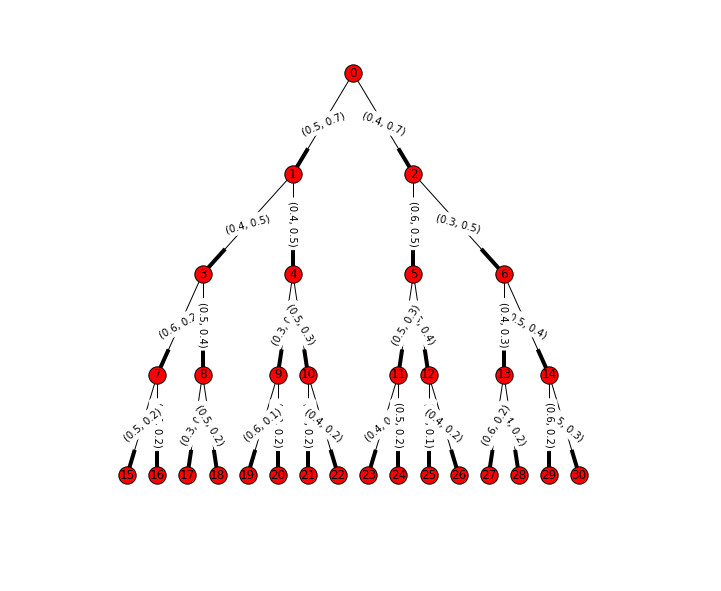

In [13]:
plt.figure(figsize=(12,10))
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
nx.draw(G,pos,with_labels=True,arrows=True)

In [14]:
{(0, 1): (0., 0.9), (1, 3): (0.7, 0.7), (1, 4): (0.7, 0.7), (2, 6): (0.3, 0.6), (2, 5): (0.9, 0.8), (0, 2): (0.5, 0.9)}

{(0, 1): (0.0, 0.9),
 (0, 2): (0.5, 0.9),
 (1, 3): (0.7, 0.7),
 (1, 4): (0.7, 0.7),
 (2, 5): (0.9, 0.8),
 (2, 6): (0.3, 0.6)}